# Lets create a patient

In [1]:
example_patient = {
    "age": 45,
    "weight": 85,
    "height": 180,
    "sex": 'm',
}

In [2]:
from PyTCI.models import propofol

pt1 = propofol.Schnider(example_patient["age"], example_patient["weight"], example_patient["height"], example_patient["sex"])
pt2 = propofol.Marsh(example_patient["weight"])

from IPython.display import Markdown

Markdown("""
### Resulting pharmacokinetic values

| Model | V1 | V2 | V3 | CL |
| ----- | --- | ----- | ----- | ----- |
| Schnider | {pt1v1} | {pt1v2} | {pt1v3} | {pt1k10} |
| Marsh | {pt2v1} | {pt2v2} | {pt2v3} | {pt2k10} |
""".format(pt1v1 = round(pt1.v1, 2), pt1v2 = round(pt1.v2, 2), pt1v3 = round(pt1.v3, 2), pt1k10 = round(pt1.k10* 60, 2),
           pt2v1 = round(pt2.v1, 2), pt2v2 = round(pt2.v2, 2), pt2v3 = round(pt2.v3), pt2k10 = round(pt2.k10* 60, 2)
))


### Resulting pharmacokinetic values

| Model | V1 | V2 | V3 | CL |
| ----- | --- | ----- | ----- | ----- |
| Schnider | 4.27 | 22.03 | 238 | 0.45 |
| Marsh | 19.38 | 39.36 | 246 | 0.12 |


### Notes:
Marsh slower clearance

Schnider Fixed V1

<IPython.core.display.Javascript object>


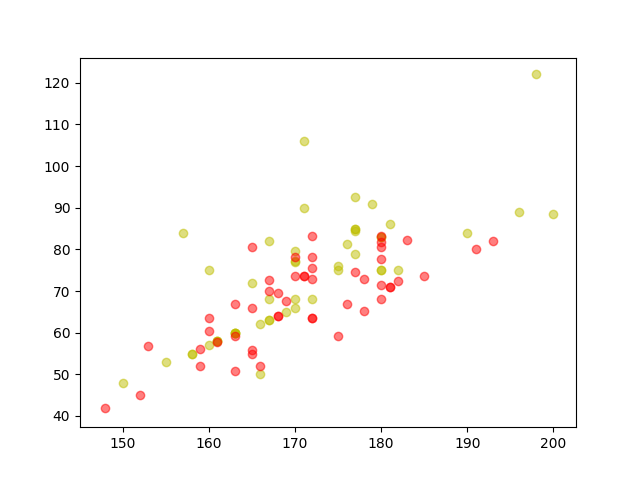

In [3]:
%matplotlib notebook

import matplotlib.pyplot as plt

from csvreader import read_patient_csv

patients = read_patient_csv()

pth = []
ptw = []
pth2 = []
ptw2 = []

for patient in patients[1:50]:
    ptw.append(patient['weight'])
    pth.append(patient['height'])
    
plt.scatter(pth, ptw, c='y', alpha=0.5)

for patient in patients[100:150]:
    ptw2.append(patient['weight'])
    pth2.append(patient['height'])
    
plt.scatter(pth2, ptw2, c='r', alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


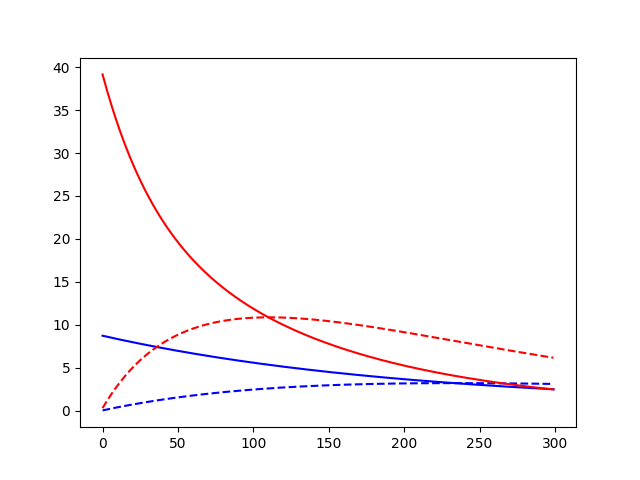

In [4]:
%matplotlib notebook

import matplotlib.pyplot as plt

marshcp = []
marshce = []
schnidercp = []
schniderce = []

# cp = 6
# dose = cp * pt2.v1
# print("Induction dose for plasma concentration of %sug/ml is: %smg" % (cp, dose)) 

dose = 170
seconds = 300

pt1.give_drug(dose)
pt2.give_drug(dose)

for _ in range(seconds):
    pt1.wait_time(1)
    pt2.wait_time(1)
    
    marshcp.append(pt2.x1)
    marshce.append(pt2.xeo)
    schnidercp.append(pt1.x1)
    schniderce.append(pt1.xeo)
    
    
induction_graph = plt.plot(marshcp, 'b', marshce, 'b--', schnidercp, 'r', schniderce, 'r--',  )


# Time to create our own model

In [5]:
from PyTCI.weights import leanbodymass
from patient_solver import solve_for_patient

class Marsden(propofol.Propofol):
    def __init__(self, age, weight, height, sex, params):
        
        lean_body_mass = leanbodymass.hume66(height, weight, sex)
        
        self.v1 = ((params[1] * 50) - params[2]*(age - (params[3] * 100))) * (params[4] * (lean_body_mass - (params[5] * 100)))
        self.v2 = params[6] * lean_body_mass * 2
        self.v3 = params[7] * weight * 5
        
        self.Q1 = (params[8] * self.v1) * (params[9] * age)
        self.Q2 = params[9]
        self.Q3 = params[0]
        
        self.keo = 0
        
        propofol.Propofol.from_clearances(self)
        propofol.Propofol.setup(self)
                                                         
                   
                   
                   
def solve_for_custom(patient, params):
    patient_model = Marsden(patient["age"], patient["weight"], patient["height"], patient["sex"], params )
    return solve_for_patient(patient_model, patient["events"])
                                                               

[0.8267, 0.8617, 0.6104, 0.5009, 0.0743, 0.7745, 0.1314, 0.0483, 0.2356, 0.1007]
[0.1816, 0.6901, 0.4048, 0.3611, 0.1293, 0.7333, 0.2144, 0.3313, 0.4629, 0.6407]


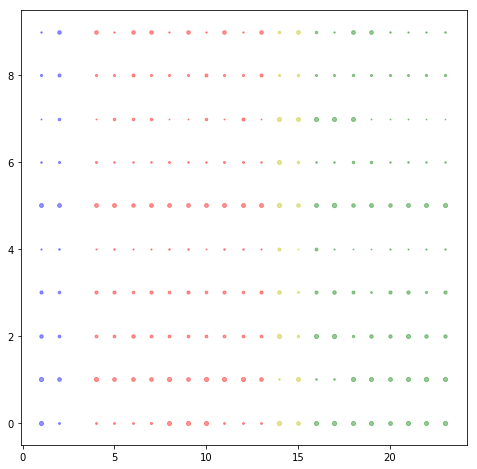

In [6]:
%matplotlib inline

from genetic_solver import mutate_population, create_new_set
plt.figure(figsize=(8,8))

setlength = 10

example_1 = create_new_set(setlength)
example_2 = create_new_set(setlength)

def plt_set(j, k, l):
    for i in range(len(j)):
        scale = j[i] * 20
        plt.scatter(k, i, s=scale, c=l, alpha=0.4)
        
plt_set(example_1, 1, 'b')
plt_set(example_2, 2, 'b')


print(example_1)
print(example_2)

pop = mutate_population(10, example_1, example_2, 4)

num = 3
for j in range(len(pop)):
    num+=1
    colour = 'r'
    if 13 < num < 16:
        colour = 'y'
    elif num > 15:
        colour = 'g'
    plt_set(pop[j], num, colour)
    

plt.show()

In [7]:
from csvreader import read_patient_csv

def test_against_real_data(stuff):
    pmin = stuff[0]
    pmax = stuff[1]
    params = stuff[2]
    patients = read_patient_csv()

    totalrms = 0
    totalmed = 0
    totalbias = 0
    count = 0

    for patient in patients[pmin:pmax]:
        res = solve_for_custom(patient, params)
        a = res["percent"]
        med = res["median"]
        bias = res["bias"]

        totalrms += a
        totalbias += bias
        totalmed += med
        count += 1

    b = totalrms / count
    c = totalmed / count
    d = totalbias / count

    data = (b, c, d)
    return data

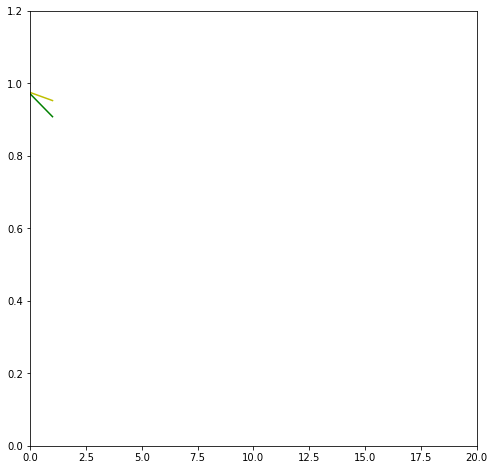

In [ ]:
from genetic_solver import create_new_population
%matplotlib inline
import time
from IPython import display
plt.figure(figsize=(8,8))
print("creatig population")
pop = create_new_population(10, 10)

def test_population(pop):

    #switching between the tuple and value is confusing and i'm getting upset
    pop_list = []
    for i in pop:
        stuff = (1, 50, i)
        try:
            result = test_against_real_data(stuff)
            fitness = result[1]
            pop_list.append([fitness, i, result])

        except:
            result = (99, 99, 99)
            fitness = result[1]
            pop_list.append([fitness, i, result])
    
    pop_list.sort()
    output = (pop_list[0][1], pop_list[0][2], pop_list[1][1], pop_list[1][2])

    return output

print("beginning test")
fit_results = test_population(pop)

fittest_set = fit_results[0]
best_fitness = fit_results[1][1]
second_set = fit_results[2]
second_fitness = fit_results[3][1]

max_tries = 0
while best_fitness > 9.9:
    fit_results = test_population(pop)
    best_fitness = fit_results[1][1]
    
    print ("trying again")    

pltB = []
pltS = []


print("starting")
plt.axis([0, 20, 0, 1.2])
for _ in range(30):
    new_pop = mutate_population(4, fittest_set, second_set, 4)
    
    fit_results = test_population(new_pop)

    fittest_set = fit_results[0]
    best_fitness = fit_results[1][1]
    second_set = fit_results[2]
    second_fitness = fit_results[3][1]
    
    pltB.append(best_fitness)
    pltS.append(second_fitness)
    
    plt.plot(pltB, 'g', pltS, 'y')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.05)

print ("finished!!")

In [ ]:
for _ in range(10):
    